# Introduction

In this notebook, we take an initial look at the data we're dealing with and do some analysis on the listings to help answer several questions. Broadly speaking we are looking to answer the question: **How do I become successful on Airbnb?** Our analysis will follow the [CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) methodology.

# Section 1: Business Understanding

To answer our main question, answering several related questions will be helpful:

**1. What are the traits of a successful Airbnb listing?**

**2. What amenities should a successful Airbnb listing provide?**

**3. Does how you much you price matter?**

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
from transformers import pipeline
from tqdm.notebook import tqdm
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['font.size'] = 16

# Section 2: Data Understanding

## Access: Load data

We will use the [Seattle Airbnb Open Data](https://www.kaggle.com/airbnb/seattle/data) to help us with our understanding

In [2]:
data_folder_name = "data/seattle"
csv_files = Path(data_folder_name).glob("*.csv")
csv_files = [x for x in csv_files]

In [3]:
[str(x.name).split(".")[0] for x in csv_files]

['reviews',
 'reviews_sentiment_predictions',
 'calendar',
 'listings',
 'reviews_sentiment_predictions_backup']

In [4]:
dfs = {}
for x in csv_files:
    dfs[str(x.name).split(".")[0]] = pd.read_csv(x)

## Exploration: First look at the data

In [5]:
def display_df_info(df):
    """
    Display info from the dataframe
    
    Input:
        df: Pandas dataframe
        
    Output:
        None: 
    """
    print("Shape:", df.shape)
    display(df)
    percentage_missing = df.isnull().sum() * 100 / len(df)
    percentage_missing_df = pd.DataFrame({"percentage_missing/%": percentage_missing})
    display(percentage_missing_df.sort_values("percentage_missing/%", ascending=False).head(10))

In [6]:
display_df_info(dfs["reviews"])

Shape: (84849, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...
...,...,...,...,...,...,...
84844,3624990,50436321,2015-10-12,37419458,Ryan,The description and pictures of the apartment ...
84845,3624990,51024875,2015-10-17,6933252,Linda,We had an excellent stay. It was clean and com...
84846,3624990,51511988,2015-10-20,19543701,Jaime,"Gran ubicación, cerca de todo lo atractivo del..."
84847,3624990,52814482,2015-11-02,24445024,Jørgen,"Very good apartement, clean and well sized. Si..."


,percentage_missing/%
comments,0.021214
listing_id,0.000000
id,0.000000
date,0.000000
reviewer_id,0.000000
reviewer_name,0.000000


In [7]:
display_df_info(dfs["calendar"])

Shape: (1393570, 4)


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
...,...,...,...,...
1393565,10208623,2016-12-29,f,NaN
1393566,10208623,2016-12-30,f,NaN
1393567,10208623,2016-12-31,f,NaN
1393568,10208623,2017-01-01,f,NaN


,percentage_missing/%
price,32.938998
listing_id,0.000000
date,0.000000
available,0.000000


In [8]:
display_df_info(dfs["listings"])

Shape: (3818, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,https://www.airbnb.com/rooms/8101950,20160104002432,2016-01-04,3BR Mountain View House in Seattle,Our 3BR/2BA house boasts incredible views of t...,"Our 3BR/2BA house bright, stylish, and wheelch...",Our 3BR/2BA house boasts incredible views of t...,none,We're located near lots of family fun. Woodlan...,...,8.0,f,NaN,WASHINGTON,f,strict,f,f,8,0.30
3814,8902327,https://www.airbnb.com/rooms/8902327,20160104002432,2016-01-04,Portage Bay View!-One Bedroom Apt,800 square foot 1 bedroom basement apartment w...,This space has a great view of Portage Bay wit...,800 square foot 1 bedroom basement apartment w...,none,The neighborhood is a quiet oasis that is clos...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,1,2.00
3815,10267360,https://www.airbnb.com/rooms/10267360,20160104002432,2016-01-04,Private apartment view of Lake WA,"Very comfortable lower unit. Quiet, charming m...",NaN,"Very comfortable lower unit. Quiet, charming m...",none,NaN,...,NaN,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN
3816,9604740,https://www.airbnb.com/rooms/9604740,20160104002432,2016-01-04,Amazing View with Modern Comfort!,Cozy studio condo in the heart on Madison Park...,Fully furnished unit to accommodate most needs...,Cozy studio condo in the heart on Madison Park...,none,Madison Park offers a peaceful slow pace upsca...,...,NaN,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN


,percentage_missing/%
license,100.000000
square_feet,97.459403
monthly_price,60.267156
security_deposit,51.126244
weekly_price,47.380828
notes,42.063908
neighborhood_overview,27.029859
cleaning_fee,26.977475
transit,24.463070
host_about,22.498690


#### Columns in listings.csv

In [9]:
for i, x in enumerate(dfs["listings"].columns):
    print("{}: {}".format(i, x))

0: id
1: listing_url
2: scrape_id
3: last_scraped
4: name
5: summary
6: space
7: description
8: experiences_offered
9: neighborhood_overview
10: notes
11: transit
12: thumbnail_url
13: medium_url
14: picture_url
15: xl_picture_url
16: host_id
17: host_url
18: host_name
19: host_since
20: host_location
21: host_about
22: host_response_time
23: host_response_rate
24: host_acceptance_rate
25: host_is_superhost
26: host_thumbnail_url
27: host_picture_url
28: host_neighbourhood
29: host_listings_count
30: host_total_listings_count
31: host_verifications
32: host_has_profile_pic
33: host_identity_verified
34: street
35: neighbourhood
36: neighbourhood_cleansed
37: neighbourhood_group_cleansed
38: city
39: state
40: zipcode
41: market
42: smart_location
43: country_code
44: country
45: latitude
46: longitude
47: is_location_exact
48: property_type
49: room_type
50: accommodates
51: bathrooms
52: bedrooms
53: beds
54: bed_type
55: amenities
56: square_feet
57: price
58: weekly_price
59: monthl

# Section 3: Prepare Data

## Clean: Let's take a look at the data for listings. First we start with cleaning the data.

In [10]:
df_listings = dfs["listings"].copy()

### Remove columns with all missing values or redundant data (only one unique value) 

In [11]:
before_cols = df_listings.shape[1]
# Remove columns with all missing values
df_listings = df_listings.dropna(how="all", axis=1)
# Remove columns with redundant data
for col in df_listings.columns:
    if len((df_listings[col]).unique())==1:
        df_listings = df_listings.drop(col, axis=1)
after_cols = df_listings.shape[1]
print("We removed {} redundant columns".format(before_cols - after_cols))

We removed 11 redundant columns


### Fix review columns
* Remove invalid rows
* Fill missing reviews with 0
* Ensure reviews are all out of 10

In [12]:
# Fix review columns
review_scores_cols = [x for x in df_listings.columns if "review_scores" in x]
# Remove all rows with invalid reviews
df_listings = df_listings.dropna(how="all", subset=review_scores_cols)
# Remove rows with no number of reviews
df_listings = df_listings.dropna(how="any", subset=["number_of_reviews"])
# Fill missing reviews with 0
df_listings[review_scores_cols] = df_listings[review_scores_cols].fillna(0)
# Make all review scores out of 10
df_listings["review_scores_rating"] = df_listings["review_scores_rating"].apply(lambda x: x/10)

### Fix other columns
* Change data type of rate columns to float
* Change data type of price columns to float
* Change data type of true-false columns to bool

In [13]:
# Fix rate columns
rate_col_list = ["host_response_rate", "host_acceptance_rate"]
for col in rate_col_list:
    df_listings[col] = df_listings[col].apply(lambda x: float(str(x).replace("%", ""))/100).fillna(0)
# Fix price columns
price_col_list = ["price",
                 "weekly_price",
                 "monthly_price",
                 "security_deposit",
                 "cleaning_fee",
                 "extra_people"]
for col in price_col_list:
    df_listings[col] = df_listings[col].apply(lambda x: float(str(x).replace("$", "").replace(",", ""))).fillna(0)
# Fix bool columns
bool_col_list = ["host_is_superhost", 
                 "host_has_profile_pic", 
                 "host_identity_verified", 
                 "require_guest_profile_picture",
                 "require_guest_phone_verification",
                 "instant_bookable"]
for col in bool_col_list:
    df_listings[col] = df_listings[col].apply(lambda x: x == "t")

### Get quantity of amenities into a column

In [14]:
# Get amenities count
df_listings["num_amenities"] = df_listings["amenities"].apply(lambda x: len(x.split(",")))

## What is our definition of success?

### Since there are 7 columns for scoring the listing, we will aggregate them so that we have a single value to compare listings.

In [15]:
def aggregate_review_score(x):
    """
    Aggregate the review score for listings
    Input:
        x: One row from dataframe
    Output:
        out: Aggregated review score
    """
    score = x["review_scores_rating"] + \
            x["review_scores_accuracy"] + \
            x["review_scores_cleanliness"] + \
            x["review_scores_checkin"] + \
            x["review_scores_communication"] + \
            x["review_scores_location"] + \
            x["review_scores_value"]
    score = (score/7)
    
    return score

In [16]:
df_listings["aggregate_score"] = [aggregate_review_score(x) for _, x in df_listings.iterrows()]

# Section 4: Evaluation

### Let's see how review scores correlate

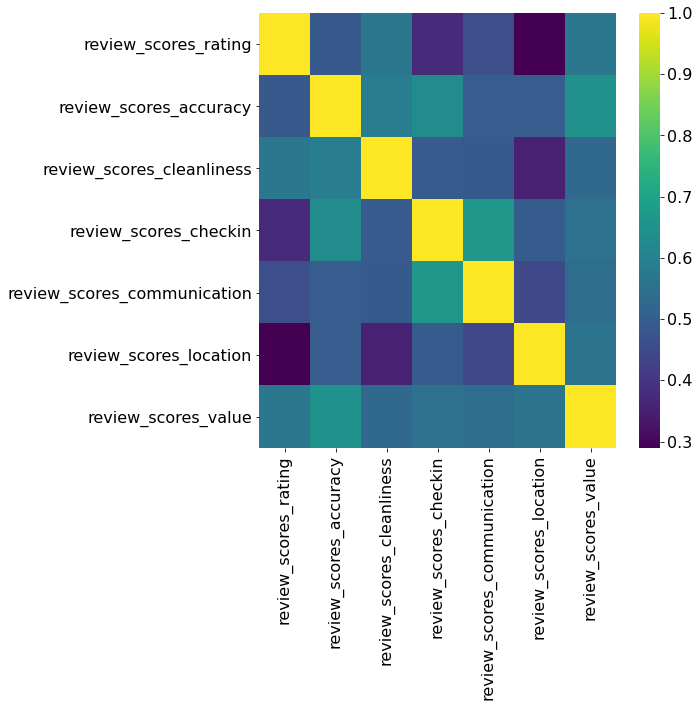

In [17]:
sns.heatmap(df_listings[review_scores_cols].corr(), cmap="viridis");

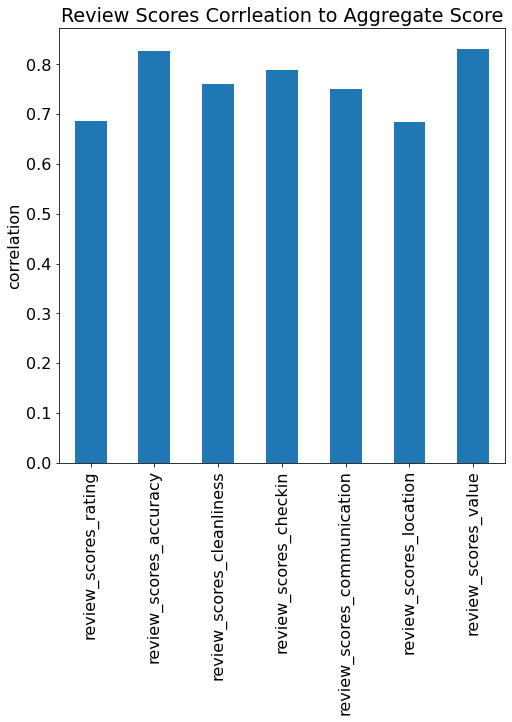

In [18]:
# Show correlationg to aggregate_score
df_listings[review_scores_cols + ["aggregate_score"]].corr().loc["aggregate_score"].drop("aggregate_score").plot(kind="bar", 
                                                                                                                 title="Review Scores Corrleation to Aggregate Score",
                                                                                                                 ylabel="correlation");

### We see that accuracy and value correlates more with the aggregate score while location and rating correlates less

### Let's have a look at the distribution of scores in the data

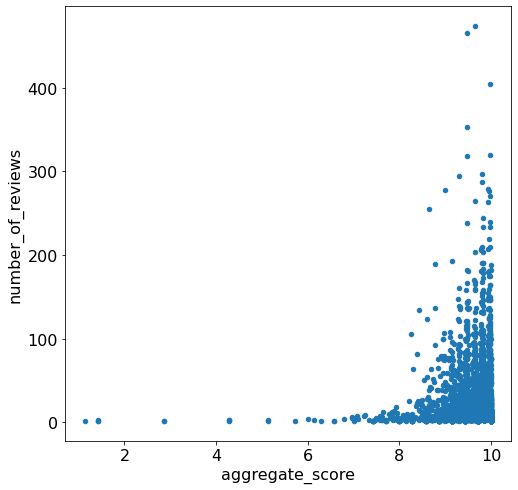

In [19]:
df_listings.plot(kind="scatter", x="aggregate_score", y="number_of_reviews");

### We see that, generally, if you have a higher number of reviews it likely means you have a high aggregate score. One possibility could be that users who review generally prefer to give a higher score. Also, there could be a positive feedback where listings with higher reviews also attract more people which results in more reviews. Consequently, those with bad reviews may not get new guests.

### To gain some insights on the traits of top performers, we will take an equal number of top and bottom performers from the data to compare.

In [20]:
# Separate into top and bottom performers
df_listings["aggregate_score_quantile"] = pd.qcut(df_listings["aggregate_score"], q=10, labels=list(range(9)), duplicates="drop").astype(int)
df_listings_topbottom = df_listings[df_listings["aggregate_score_quantile"].isin([0, 1, 8])].copy()
df_listings_topbottom["aggregate_score_quantile"] = df_listings_topbottom["aggregate_score_quantile"].replace(8, "Top Performer")
df_listings_topbottom["aggregate_score_quantile"] = df_listings_topbottom["aggregate_score_quantile"].replace(0, "Bottom Performer")
df_listings_topbottom["aggregate_score_quantile"] = df_listings_topbottom["aggregate_score_quantile"].replace(1, "Bottom Performer")
df_listings_topbottom["aggregate_score_quantile"].value_counts()

Bottom Performer    641
Top Performer       632
Name: aggregate_score_quantile, dtype: int64

## Question 1: What are the traits of a successful Airbnb listing?

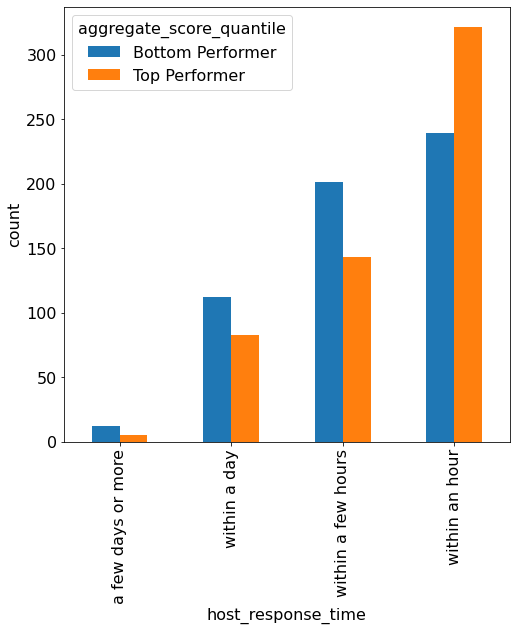

In [21]:
# Plot against host_response_time
tmp_df = df_listings_topbottom.groupby(["host_response_time", "aggregate_score_quantile"]).size().unstack()
# tmp_df["absolute_difference"] = [np.abs(x["Top Performer"] - x["Bottom Performer"]) for _, x in tmp_df.iterrows()]
# tmp_df["top_performer_percentage"] = [100*x["Top Performer"]/(x["Bottom Performer"] + x["Top Performer"]) for _, x in tmp_df.iterrows()]
tmp_df[["Bottom Performer", "Top Performer"]].plot(kind='bar', ylabel="count");

In [22]:
tmp_df.reset_index(level=0, inplace=True)

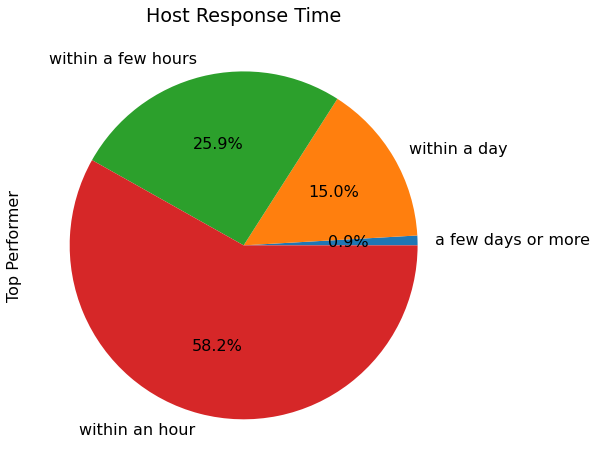

In [23]:
tmp_df.plot(kind="pie", y="Top Performer", labels=tmp_df["host_response_time"], title="Host Response Time", autopct='%1.1f%%', legend=None);

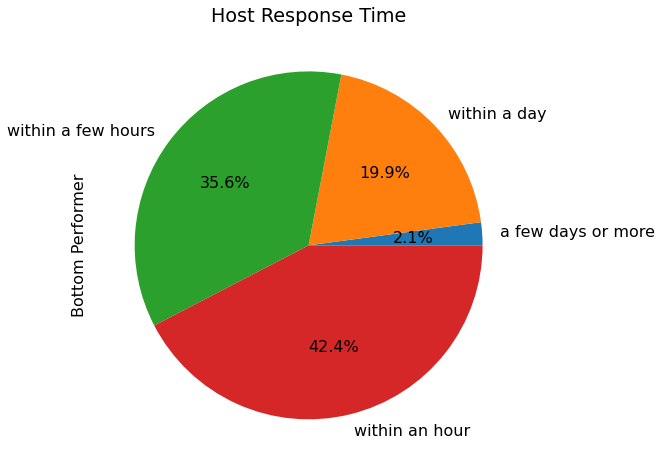

In [24]:
tmp_df.plot(kind="pie", y="Bottom Performer", labels=tmp_df["host_response_time"], title="Host Response Time", autopct='%1.1f%%', legend=None);

### No surprises here, we see that the more responsive the host is are the better your score will be. 58.2% of top performers respond within an hour as opposed to the 42.4% of bottom performers.

If you host_is_superhost you are 90.15% likely to be a top performer. If you aren't, you are only 41.96% likely.
If you host_identity_verified you are 50.75% likely to be a top performer. If you aren't, you are only 45.62% likely.
If you require_guest_profile_picture you are 34.58% likely to be a top performer. If you aren't, you are only 51.03% likely.
If you require_guest_phone_verification you are 34.21% likely to be a top performer. If you aren't, you are only 51.16% likely.
If you instant_bookable you are 49.19% likely to be a top performer. If you aren't, you are only 49.72% likely.


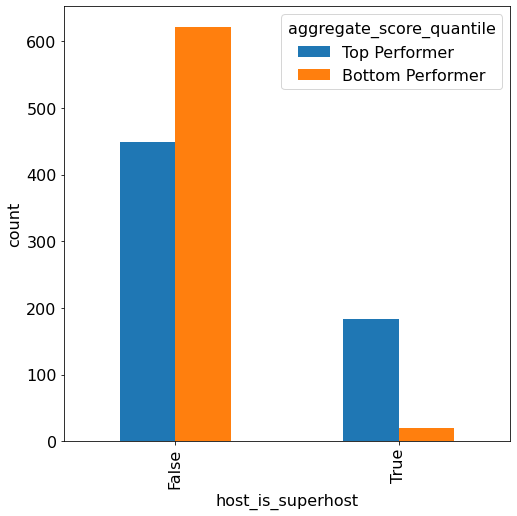

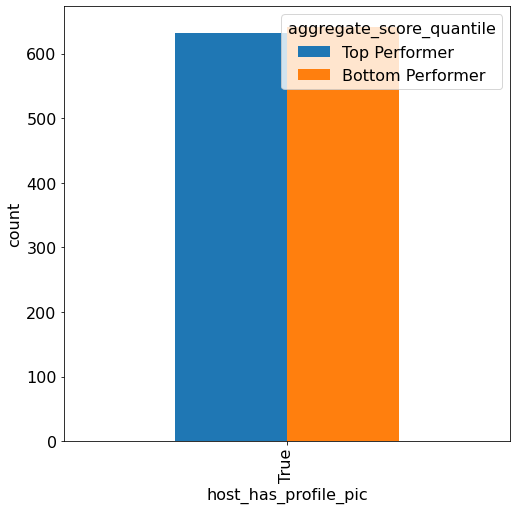

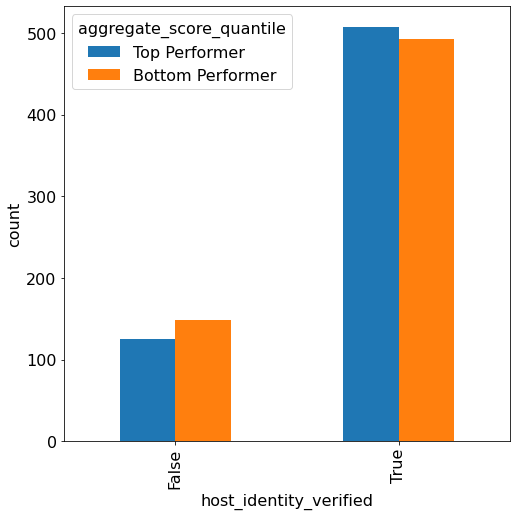

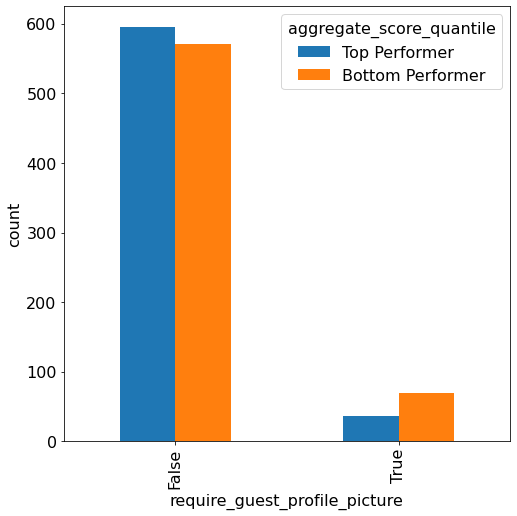

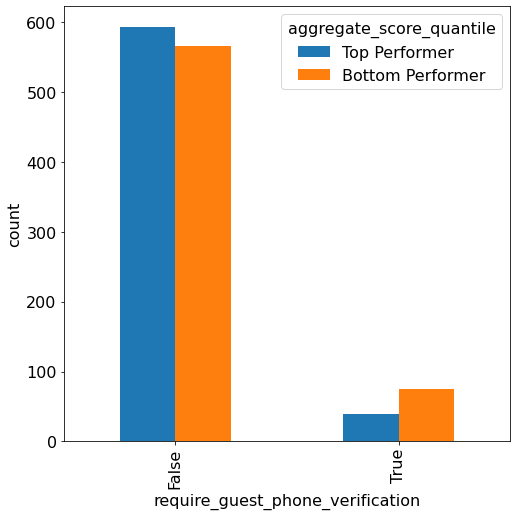

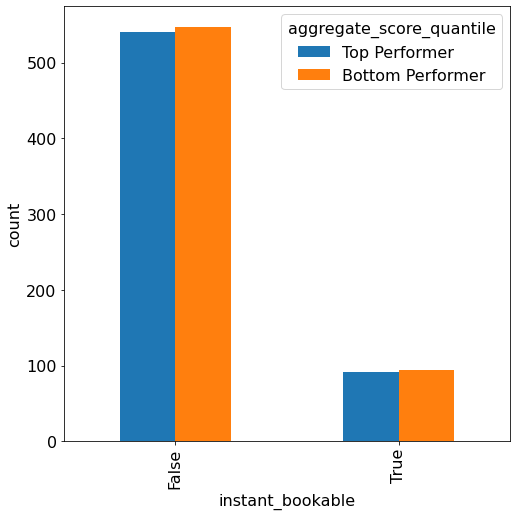

In [25]:
# Plot against host_is_superhost
for col in bool_col_list:
    tmp_df = df_listings_topbottom.groupby([col, "aggregate_score_quantile"]).size().unstack()
#     tmp_df["absolute_difference"] = [np.abs(x["Top Performer"] - x["Bottom Performer"]) for _, x in tmp_df.iterrows()]
    tmp_df["top_performer_percentage"] = [100*x["Top Performer"]/(x["Bottom Performer"] + x["Top Performer"]) for _, x in tmp_df.iterrows()]
    if len(tmp_df["top_performer_percentage"]) > 1:
        print("If you {} you are {:.2f}% likely to be a top performer. If you aren't, you are only {:.2f}% likely.".format(col, tmp_df["top_performer_percentage"][1], tmp_df["top_performer_percentage"][0]))
    tmp_df[["Top Performer", "Bottom Performer"]].plot(kind='bar', ylabel="count");

In [26]:
# tmp_df = df_listings_topbottom.groupby(["host_is_superhost", "aggregate_score_quantile"]).size().unstack()
# tmp_df.reset_index(level=0, inplace=True)

In [27]:
# tmp_df.plot(kind="pie", y="Top Performer", labels=["No", "Yes"], title="Is a Superhost?", autopct='%1.1f%%', legend=None);

In [28]:
# tmp_df.plot(kind="pie", y="Bottom Performer", labeltmp_df.plot(kind="pie", y="Bottom Performer", labels=["No", "Yes"], title="Is a Superhost?", autopct='%1.1f%%', legend=None);s=["No", "Yes"], title="Is a Superhost?", autopct='%1.1f%%', legend=None);

### Comparing these plots, the only trait that stands out is being a superhost. Comparing top and bottom performers, 90.15% of Superhosts are top performers whereas only 41.96% of non-Superhosts are top performers.

## Question 2: What amenities should a successful Airbnb listing provide?

### We will now look at how amenities affect your score

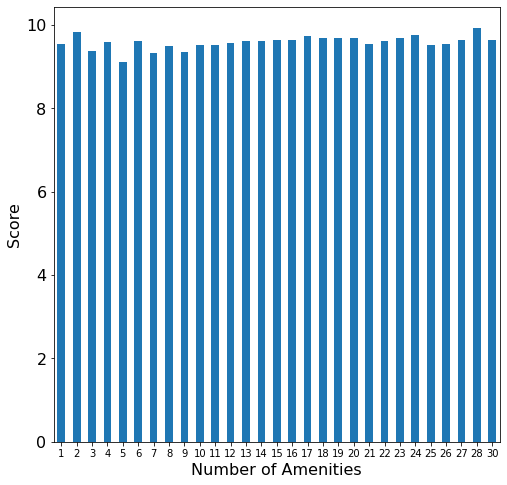

In [29]:
df_listings.groupby("num_amenities")["aggregate_score"].mean().plot(kind="bar", ylabel="mean_aggregate_score");
plt.xticks(rotation = 0, fontsize = 10);
plt.ylabel("Score");
plt.xlabel("Number of Amenities");

### Having more or less amenities doesn't affect your score much

In [30]:
amenities_count = {}
amenities_count["Top Performer"] = {}
amenities_count["Bottom Performer"] = {}

# Get count for each amenity listed
for _, row in df_listings_topbottom.iterrows():
    amenities = row["amenities"].replace("{", "").replace("}", "").replace("\"", "")
    amenities = amenities.replace("Washer / Dryer", "Washer,Dryer")
    if "," in amenities:
        amenities = amenities.split(",")
    for a in amenities:
        if a not in amenities_count[row["aggregate_score_quantile"]]:
            amenities_count[row["aggregate_score_quantile"]][a] = 1
        else:
            amenities_count[row["aggregate_score_quantile"]][a] += 1

In [31]:
amenities_df = pd.DataFrame(amenities_count)
amenities_df["Top Performer Percentage/%"] = [100*x["Top Performer"]/(x["Bottom Performer"] + x["Top Performer"]) for _, x in amenities_df.iterrows()]
# amenities_df["absolute_difference"] = [np.abs(x["Top Performer"] - x["Bottom Performer"]) for _, x in amenities_df.iterrows()]

In [32]:
amenities_df.sort_values(by="Top Performer Percentage/%", ascending=False).head(10)

,Top Performer,Bottom Performer,Top Performer Percentage/%
Doorman,16,5,76.190476
Laptop Friendly Workspace,141,63,69.117647
Safety Card,166,90,64.843750
24-Hour Check-in,108,61,63.905325
Cat(s),71,41,63.392857
Hangers,152,88,63.333333
Iron,133,78,63.033175
Hair Dryer,137,81,62.844037
Lock on Bedroom Door,9,6,60.000000
Air Conditioning,116,79,59.487179


In [33]:
amenities_df.sort_values(by="Top Performer Percentage/%", ascending=True).head(10)

,Top Performer,Bottom Performer,Top Performer Percentage/%
Other pet(s),6,12,33.333333
Suitable for Events,28,52,35.000000
Hot Tub,38,60,38.775510
Pool,22,30,42.307692
Wheelchair Accessible,48,57,45.714286
Gym,65,77,45.774648
Pets Allowed,81,93,46.551724
Elevator in Building,127,137,48.106061
Family/Kid Friendly,317,327,49.223602
Internet,464,474,49.466951


#### Here, we see that the amenities you should have if you are more likely to be a top performer are a Doorman, Safety Card, and 24-Hour Check-in showing that guests really care about flexibility and safety. 

#### Mosts of the guests could also be travelling for work as a Laptop Friendly Workspace can make the difference. 

#### A lot of love for cats but not other pets unfortunately. 

#### Guests are happier if they have utilities to manage their laundry.

#### Good news however as a Hot Tub will be unnescessary. Also, making your listing Suitable for Events will not help you become a top performer, infact, it could even deteriorate your performance.

## Question 3: Does how you much you price matter?

### Here we take a quick look at the price distribution for top and bottom performers

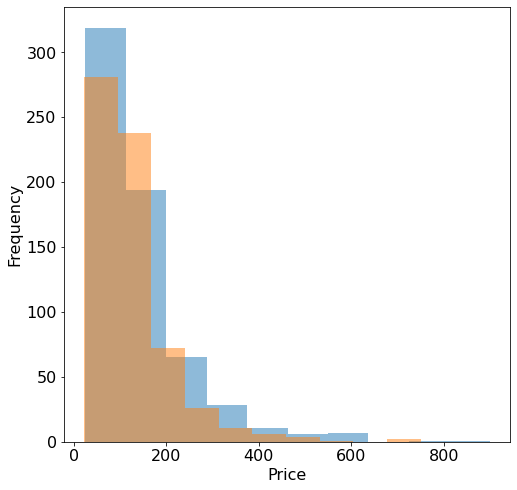

In [35]:
fig = plt.figure()
df_listings_topbottom[df_listings_topbottom["aggregate_score_quantile"] == "Top Performer"]["price"].plot(kind="hist", alpha=0.5);
df_listings_topbottom[df_listings_topbottom["aggregate_score_quantile"] == "Bottom Performer"]["price"].plot(kind="hist", alpha=0.5);
plt.xlabel("Price");

### The price distributions for bottom and top performers look identical which means that pricing doesn't matter as much

# Conclusion

If you want to be a top performer on Airbnb, keep these notes in mind:
* **Be responsive**
* **Having the Superhost status really helps**
* **Make it convenient for your guest to move in**
    * Doorman, 24-hour check-in
* **Make them feel safe and comfortable**
    * Safety card, air conditioning
* **People care about laundry management and grooming**
    * Hangers, irons, and hair dryers 
* **Cater to those travelling for work**
    * Laptop friendly workspace
* **People like cats**

Additional notes:
* **Pricing doesn't matter**
* **Number of amenities you provide doesn't matter**
* **If you have a high number of reviews, you are likely to perform better**
* **Hot tubs, pools, and, gyms are less important**